# Import Libraries

In [1]:
!pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

# Initial setup

In [2]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available? ", cuda)

device = "cuda:0" if cuda else "cpu"

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available?  True


# Data Augmentation

In [3]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) 
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


# Dataset and Dataloaders

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [5]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


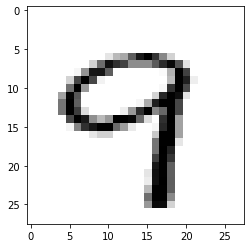

In [6]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


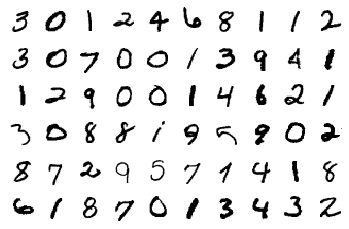

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(num_of_images // 10, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model

In [28]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        dropout_prob = 0.1
        self.input_block = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=0),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout2d(dropout_prob)
        )
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(8, 8, 3, padding=0),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout2d(dropout_prob)
        )

        self.transition_1 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Conv2d(8, 8, 1, padding=0),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout2d(dropout_prob)
        )
     
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(dropout_prob)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(16, 16, 3, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(dropout_prob)
        )

        self.transition_2 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 8, 1, padding=0),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout2d(dropout_prob)
        )
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(8, 16, 3, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(dropout_prob)
        )

        self.conv_block_5 = nn.Sequential(
            nn.Conv2d(16, 10, 2, padding=0)
        )

    def forward(self, x):
        x = self.input_block(x)
        x = self.conv_block_1(x)
        x = self.transition_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.transition_2(x)
        x = self.conv_block_4(x)
        x = self.conv_block_5(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [29]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
         Dropout2d-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             584
       BatchNorm2d-6            [-1, 8, 24, 24]              16
              ReLU-7            [-1, 8, 24, 24]               0
         Dropout2d-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]              72
      BatchNorm2d-11            [-1, 8, 12, 12]              16
             ReLU-12            [-1, 8, 12, 12]               0
        Dropout2d-13            [-1, 8, 12, 12]               0
           Conv2d-14           [-1, 16,

# Training and Testing

In [19]:
from pkbar import Kbar

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = Kbar(len(train_loader), width=12)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        # getting data
        data, target = data.to(device), target.to(device)

        # zeroing out leftover gradients
        optimizer.zero_grad()

        # predict
        y_pred = model(data)

        # calculating loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # backpropagation
        loss.backward()
        optimizer.step()
        
        # calculating accuracy
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        acc = 100*correct/processed
        train_acc.append(acc)

        # updating progress bar
        pbar.update(batch_idx, values=[('loss', loss.item()), ('accuracy', acc)])
        
    pbar.add(1, values=[('loss', loss.item()), ('accuracy', acc)])

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [27]:
optimizer = optim.SGD(model.parameters(), lr=0.3, momentum=0.9)
epochs = 15
for epoch in range(epochs):
    print("Epoch:", epoch + 1, "/", epochs)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Epoch: 1 / 15
469/469 [============] - 7s 14ms/step - loss: 0.0612 - accuracy: 98.0931
Test set: Average loss: 0.0355, Accuracy: 9894/10000 (98.94%)

Epoch: 2 / 15
469/469 [============] - 7s 14ms/step - loss: 0.0602 - accuracy: 98.1695
Test set: Average loss: 0.0312, Accuracy: 9909/10000 (99.09%)

Epoch: 3 / 15
469/469 [============] - 7s 14ms/step - loss: 0.0599 - accuracy: 98.1521
Test set: Average loss: 0.0305, Accuracy: 9905/10000 (99.05%)

Epoch: 4 / 15
469/469 [============] - 7s 15ms/step - loss: 0.0615 - accuracy: 98.0410
Test set: Average loss: 0.0313, Accuracy: 9905/10000 (99.05%)

Epoch: 5 / 15
469/469 [============] - 7s 14ms/step - loss: 0.0611 - accuracy: 98.1271
Test set: Average loss: 0.0324, Accuracy: 9899/10000 (98.99%)

Epoch: 6 / 15
469/469 [============] - 7s 14ms/step - loss: 0.0601 - accuracy: 98.1075
Test set: Average loss: 0.0344, Accuracy: 9896/10000 (98.96%)

Epoch: 7 / 15
469/469 [============] - 7s 14ms/step - loss: 0.0607 - accuracy: 98.2623
Test set: Ave

Text(0.5, 1.0, 'Test Accuracy')

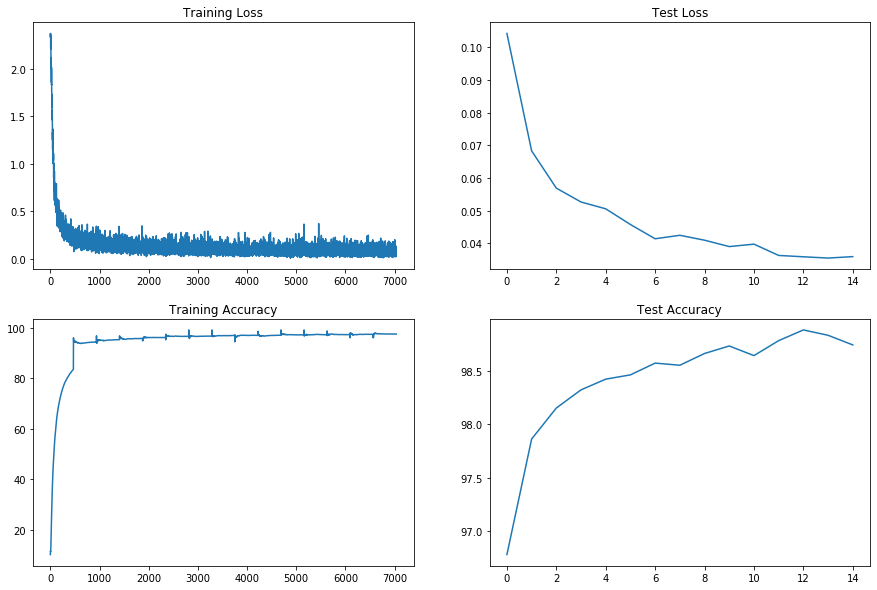

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")